In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import zscore
from scipy.stats import stats
from scipy.stats import linregress
import os
import seaborn as sns
import re
import datetime

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [93]:
# Files to Load (csv files downloaded from the internet)

file1 = "data/population-density-vs-prosperity.csv"
file2 = "data/urban-and-rural-population.csv"
file3 = "data/urban-vs-rural-majority.csv"
file4 = "data/life-expectancy-at-birth-total-years.csv"
file5 = "data/median-age.csv"
file6 = "data/six-dem_mod.csv"
file7 = "data/covid-confirmed-cases-since-100th-case_hkg.csv"

# Read File and store into Pandas data frame

density_vs_prosperity = pd.read_csv(file1)
urban_rural_population = pd.read_csv(file2)
urban_vs_rural_majority = pd.read_csv(file3)
life_expectancy = pd.read_csv(file4)
median_age = pd.read_csv(file5)
hoefstede = pd.read_csv(file6)
covid_data = pd.read_csv(file7, parse_dates=['Date'])

In [94]:
density_vs_prosperity.shape

(47234, 6)

In [95]:
density_vs_prosperity.dropna(subset=['Code'],inplace=True)
density_vs_prosperity.shape

(44392, 6)

In [96]:
urban_rural_population.dropna(subset=['Code'],inplace=True)
urban_rural_population.shape

(12363, 5)

In [97]:
urban_vs_rural_majority.dropna(subset=['Code'],inplace=True)
urban_vs_rural_majority.shape

(24019, 5)

In [98]:
life_expectancy.dropna(subset=['Code'],inplace=True)
life_expectancy.shape

(11125, 4)

In [99]:
median_age.dropna(subset=['Code'],inplace=True)
median_age.shape

(6324, 4)

In [100]:
hoefstede.shape

(127, 8)

In [101]:
hoefstede = hoefstede.replace('#NULL!','')

In [105]:
hoefstede[['pdi','idv','mas','uai','ltowvs','ivr']] = hoefstede[['pdi','idv','mas','uai','ltowvs','ivr']].apply(pd.to_numeric)

In [107]:
covid_data.shape

(12768, 5)

In [108]:
# Merge data
merged_data = pd.merge(density_vs_prosperity, urban_rural_population, on=["Entity","Code", "Year"])
merged_data.shape

(12283, 8)

In [109]:
merged_data = pd.merge(merged_data, urban_vs_rural_majority, on=["Entity", "Code", "Year"])
merged_data.shape

(12283, 10)

In [110]:
merged_data = pd.merge(merged_data, life_expectancy, on=["Entity", "Code", "Year"])
merged_data.shape

(11007, 11)

In [111]:
#merged_data.head()

,Entity,Code,Year,Population density (people per km² of land area),GDP per capita (constant 2011 international $),Total population (Gapminder),Urban population,Rural population,Urban (%),Rural (%),"Life expectancy at birth, total (years) (years)"
0,Afghanistan,AFG,1960,NaN,NaN,8996351.0,755783,8240568,8.401,91.598999,32.292
1,Afghanistan,AFG,1961,14.040934,NaN,9166764.0,796042,8370722,8.684,91.316002,32.742
2,Afghanistan,AFG,1962,14.315271,NaN,9345868.0,838885,8506983,8.976,91.024002,33.185
3,Afghanistan,AFG,1963,14.603367,NaN,9533954.0,884370,8649584,9.276,90.723999,33.624
4,Afghanistan,AFG,1964,14.905739,NaN,9731361.0,932848,8798513,9.586,90.414001,34.060


In [112]:
merged_data = pd.merge(merged_data, median_age, on=["Entity", "Code", "Year"])
merged_data.shape

(2280, 12)

In [113]:
#Format columns
merged_data = merged_data.rename(columns={"Population density (people per km² of land area)": "pop_density",
                                          "GDP per capita (constant 2011 international $)" : "gdp",
                                         "Total population (Gapminder)": "total_pop",
                                         "Urban population": "urban_pop",
                                         "Rural population": "rural_pop",
                                         "Urban (%)":"urban_pct",
                                         "Rural (%)": "rural_pct",
                                         "Life expectancy at birth, total (years) (years)":"life_expectancy",
                                         "UN Population Division (Median Age) (2017) (years)":"median_age"})
#merged_data.head()

,Entity,Code,Year,pop_density,gdp,total_pop,urban_pop,rural_pop,urban_pct,rural_pct,life_expectancy,median_age
0,Afghanistan,AFG,1960,NaN,NaN,8996351.0,755783,8240568,8.401,91.598999,32.292,18.799999
1,Afghanistan,AFG,1965,15.222887,NaN,9938414.0,984301,8954113,9.904,90.096001,34.495,18.400000
2,Afghanistan,AFG,1970,17.042127,NaN,11126123.0,1295415,9830708,11.643,88.357002,36.678,17.900000
3,Afghanistan,AFG,1975,19.284818,NaN,12590286.0,1717441,10872845,13.641,86.359001,39.039,17.400000
4,Afghanistan,AFG,1980,20.292819,NaN,13248370.0,2119077,11129293,15.995,84.004997,41.853,17.000000


In [114]:
hoefstede.shape

(127, 8)

In [115]:
#hoefstede.head()

,ctr,country,pdi,idv,mas,uai,ltowvs,ivr
0,GTM,Guatemala,95.0,6.0,37.0,101.0,NaN,NaN
1,ECU,Ecuador,78.0,8.0,63.0,67.0,NaN,NaN
2,PAN,Panama,95.0,11.0,44.0,86.0,NaN,NaN
3,VEN,Venezuela,81.0,12.0,73.0,76.0,16.0,100.0
4,COL,Colombia,67.0,13.0,64.0,80.0,13.0,83.0


In [116]:
hoefstede = hoefstede.rename(columns={"ctr": "Code",
                                          "country" : "Entity"})
#hoefstede.head()

,Code,Entity,pdi,idv,mas,uai,ltowvs,ivr
0,GTM,Guatemala,95.0,6.0,37.0,101.0,NaN,NaN
1,ECU,Ecuador,78.0,8.0,63.0,67.0,NaN,NaN
2,PAN,Panama,95.0,11.0,44.0,86.0,NaN,NaN
3,VEN,Venezuela,81.0,12.0,73.0,76.0,16.0,100.0
4,COL,Colombia,67.0,13.0,64.0,80.0,13.0,83.0


In [117]:
covid_data.shape

(12768, 5)

In [118]:
merged_data = pd.merge(merged_data, hoefstede, on=[ "Code"])
#merged_data.head()

,Entity_x,Code,Year,pop_density,gdp,total_pop,urban_pop,rural_pop,urban_pct,rural_pct,life_expectancy,median_age,Entity_y,pdi,idv,mas,uai,ltowvs,ivr
0,Albania,ALB,1960,NaN,NaN,1636056.0,493982,1114818,30.705,69.294998,62.279,20.200001,Albania,90.0,20.0,80.0,70.0,61.0,15.0
1,Albania,ALB,1965,68.058066,NaN,1896125.0,582374,1282417,31.230,68.769997,65.848,19.700001,Albania,90.0,20.0,80.0,70.0,61.0,15.0
2,Albania,ALB,1970,77.937190,NaN,2150598.0,677801,1457678,31.740,68.260002,66.933,19.600000,Albania,90.0,20.0,80.0,70.0,61.0,15.0
3,Albania,ALB,1975,87.767555,NaN,2411229.0,786668,1618163,32.712,67.288002,68.734,20.200001,Albania,90.0,20.0,80.0,70.0,61.0,15.0
4,Albania,ALB,1980,97.518139,NaN,2681239.0,902120,1769877,33.762,66.237999,70.207,21.400000,Albania,90.0,20.0,80.0,70.0,61.0,15.0


In [119]:
merged_data.shape

(1381, 19)

In [120]:
merged_data['Year'].max()

2015

In [121]:
merged_data = merged_data[merged_data["Year"] == 2015]
#merged_data.head()

,Entity_x,Code,Year,pop_density,gdp,total_pop,urban_pop,rural_pop,urban_pct,rural_pct,life_expectancy,median_age,Entity_y,pdi,idv,mas,uai,ltowvs,ivr
11,Albania,ALB,2015,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,36.200001,Albania,90.0,20.0,80.0,70.0,61.0,15.0
23,Algeria,DZA,2015,16.740504,13724.723853,39871528.0,28248180,11623348,70.848,29.152000,75.860,27.500000,Algeria,NaN,NaN,NaN,NaN,26.0,32.0
35,Angola,AGO,2015,22.346439,6227.664689,27859305.0,17675615,10183690,63.446,36.554001,61.241,16.400000,Angola,83.0,18.0,20.0,60.0,15.0,83.0
47,Argentina,ARG,2015,15.865065,19116.907915,43417765.0,39728558,3689207,91.503,8.497000,76.415,30.799999,Argentina,49.0,46.0,56.0,86.0,20.0,62.0
59,Armenia,ARM,2015,102.456972,8195.933650,2916950.0,1840158,1076792,63.085,36.915001,74.445,33.900002,Armenia,NaN,NaN,NaN,NaN,61.0,NaN


In [122]:
merged_data.drop(['Entity_y','Year'], axis=1,inplace=True)

In [123]:
merged_data = merged_data.rename(columns={"Entity_x": "Entity"})

In [124]:
#merged_data.head()

,Entity,Code,pop_density,gdp,total_pop,urban_pop,rural_pop,urban_pct,rural_pct,life_expectancy,median_age,pdi,idv,mas,uai,ltowvs,ivr
11,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,36.200001,90.0,20.0,80.0,70.0,61.0,15.0
23,Algeria,DZA,16.740504,13724.723853,39871528.0,28248180,11623348,70.848,29.152000,75.860,27.500000,NaN,NaN,NaN,NaN,26.0,32.0
35,Angola,AGO,22.346439,6227.664689,27859305.0,17675615,10183690,63.446,36.554001,61.241,16.400000,83.0,18.0,20.0,60.0,15.0,83.0
47,Argentina,ARG,15.865065,19116.907915,43417765.0,39728558,3689207,91.503,8.497000,76.415,30.799999,49.0,46.0,56.0,86.0,20.0,62.0
59,Armenia,ARM,102.456972,8195.933650,2916950.0,1840158,1076792,63.085,36.915001,74.445,33.900002,NaN,NaN,NaN,NaN,61.0,NaN


In [125]:
merged_data.shape

(116, 17)

In [126]:
#covid_data.head()

,Entity,Code,Date,(cases),Number of days since the 100th confirmed case (days)
0,Afghanistan,AFG,2019-12-31,0.0,NaN
1,Afghanistan,AFG,2020-01-01,0.0,NaN
2,Afghanistan,AFG,2020-01-02,0.0,NaN
3,Afghanistan,AFG,2020-01-03,0.0,NaN
4,Afghanistan,AFG,2020-01-04,0.0,NaN


In [127]:
merged_data = pd.merge(merged_data, covid_data, on=[ "Code"])
#merged_data.head()

,Entity_x,Code,pop_density,gdp,total_pop,urban_pop,rural_pop,urban_pct,rural_pct,life_expectancy,...,pdi,idv,mas,uai,ltowvs,ivr,Entity_y,Date,(cases),Number of days since the 100th confirmed case (days)
0,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,Albania,2020-03-09,2.0,NaN
1,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,Albania,2020-03-10,6.0,NaN
2,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,Albania,2020-03-11,10.0,NaN
3,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,Albania,2020-03-12,11.0,NaN
4,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,Albania,2020-03-13,23.0,NaN


In [128]:
merged_data.drop(['Entity_y'], axis=1,inplace=True)

In [129]:
merged_data = merged_data.rename(columns={"Entity_x": "Entity",
                                         " (cases)" : "cases",
                                          "Number of days since the 100th confirmed case (days)":"days_gt_100"})

In [130]:
merged_data.shape

(7981, 20)

In [131]:
#merged_data.tail()

,Entity,Code,pop_density,gdp,total_pop,urban_pop,rural_pop,urban_pct,rural_pct,life_expectancy,median_age,pdi,idv,mas,uai,ltowvs,ivr,Date,cases,days_gt_100
7976,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-11,11.0,NaN
7977,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-12,14.0,NaN
7978,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-13,14.0,NaN
7979,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-14,17.0,NaN
7980,Zimbabwe,ZWE,40.784415,1912.280261,15777451.0,5109528,10667923,32.385,67.614998,60.398,19.0,NaN,NaN,NaN,NaN,15.0,28.0,2020-04-15,17.0,NaN


In [132]:
# Drop rows where days_gt_100 is null
#merged_data = merged_data[merged_data.days_gt_100 != 0]
merged_data.dropna(subset=['days_gt_100'],inplace=True)
merged_data.shape

(2916, 20)

In [133]:
merged_data['log_cases'] = np.log(merged_data['cases'])

In [135]:
#merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 15 to 7926
Data columns (total 21 columns):
Entity             2916 non-null object
Code               2916 non-null object
pop_density        2916 non-null float64
gdp                2895 non-null float64
total_pop          2898 non-null float64
urban_pop          2916 non-null int64
rural_pop          2916 non-null int64
urban_pct          2916 non-null float64
rural_pct          2916 non-null float64
life_expectancy    2916 non-null float64
median_age         2916 non-null float64
pdi                2674 non-null float64
idv                2674 non-null float64
mas                2674 non-null float64
uai                2674 non-null float64
ltowvs             2675 non-null float64
ivr                2595 non-null float64
Date               2916 non-null datetime64[ns]
cases              2916 non-null float64
days_gt_100        2916 non-null float64
log_cases          2916 non-null float64
dtypes: datetime64[ns](1), flo

In [136]:
# Export CSV
merged_data.to_csv('merged_data_modified.csv')  

In [137]:
merged_data['Date'] = pd.to_timedelta(merged_data['Date']).dt.total_seconds().astype(int)
#merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='%Y-%m-%d').dt.time

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.


In [138]:
#merged_data.head()

,Entity,Code,pop_density,gdp,total_pop,urban_pop,rural_pop,urban_pct,rural_pct,life_expectancy,...,pdi,idv,mas,uai,ltowvs,ivr,Date,cases,days_gt_100,log_cases
15,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,1585008000,100.0,0.0,4.605170
16,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,1585094400,123.0,1.0,4.812184
17,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,1585180800,146.0,2.0,4.983607
18,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,1585267200,174.0,3.0,5.159055
19,Albania,ALB,105.135146,10970.452245,2923352.0,1654503,1226200,57.434,42.566002,78.174,...,90.0,20.0,80.0,70.0,61.0,15.0,1585353600,186.0,4.0,5.225747


## Create subset of Countries that have reached 5 days > 100 cases

In [139]:
cases5 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 5).sum())>0]

In [140]:
cases5group = cases5.groupby('Code')

In [141]:
cases5slopes = (cases5group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))

In [142]:
merged5 = merged_data[merged_data.days_gt_100 == 5]

In [143]:
mergedcases5 = pd.merge(merged5, cases5slopes, on=["Code"])

In [144]:
#mergedcases5.dropna(subset=['idv'],inplace=True)

In [145]:
# Export CSV
mergedcases5.to_csv('cases5.csv')  

In [146]:
corr5 = mergedcases5.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 5 days since 100th Covid case')

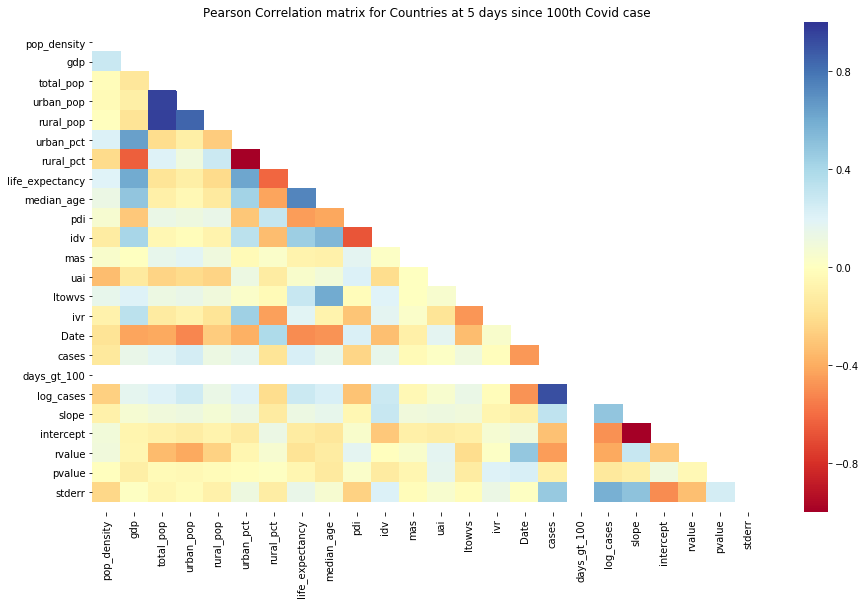

In [149]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr5)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr5,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 5 days since 100th Covid case')

In [150]:
corr5.to_csv('corrcases5.csv')

## Create subset of Countries that have reached 10 days > 100 cases

In [151]:
cases10 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 10).sum())>0]

In [152]:
cases10group = cases10.groupby('Code')

In [153]:
cases10slopes = (cases10group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))

In [154]:
merged10 = merged_data[merged_data.days_gt_100 == 10]

In [155]:
mergedcases10 = pd.merge(merged10, cases10slopes, on=["Code"])

In [157]:
# Export CSV
mergedcases10.to_csv('cases10.csv')  

In [158]:
corr10 = mergedcases10.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 10 days since 100th Covid case')

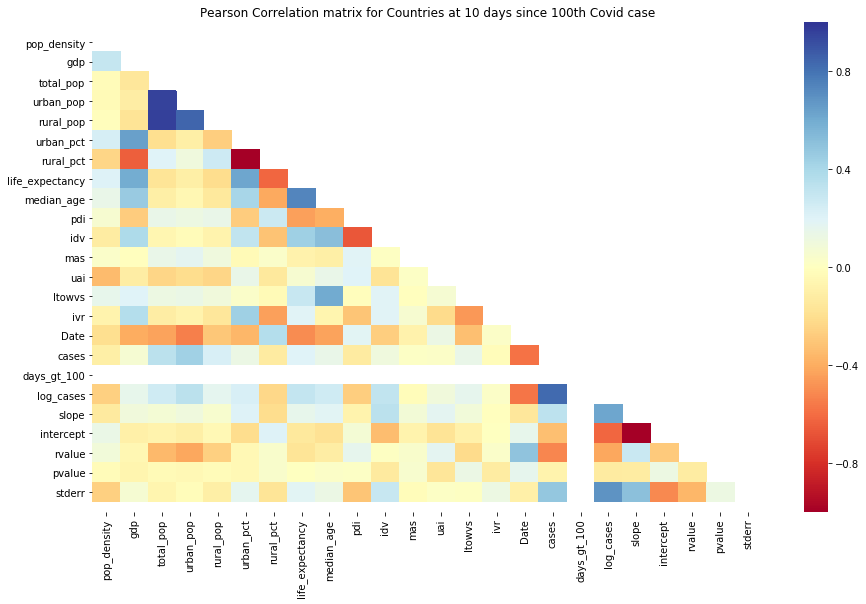

In [160]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr10)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr10,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 10 days since 100th Covid case')

In [161]:
corr10.to_csv('corrcases10.csv')

## Create subset of Countries that have reached 20 days > 100 cases

In [162]:
cases20 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 20).sum())>0]

In [164]:
cases20group = cases20.groupby('Code')

In [165]:
cases20slopes = (cases20group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))

In [166]:
merged20 = merged_data[merged_data.days_gt_100 == 20]

In [167]:
mergedcases20 = pd.merge(merged20, cases20slopes, on=["Code"])

In [168]:
# Export CSV
mergedcases20.to_csv('cases20.csv')  

In [169]:
corr20 = mergedcases20.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 20 days since 100th Covid case')

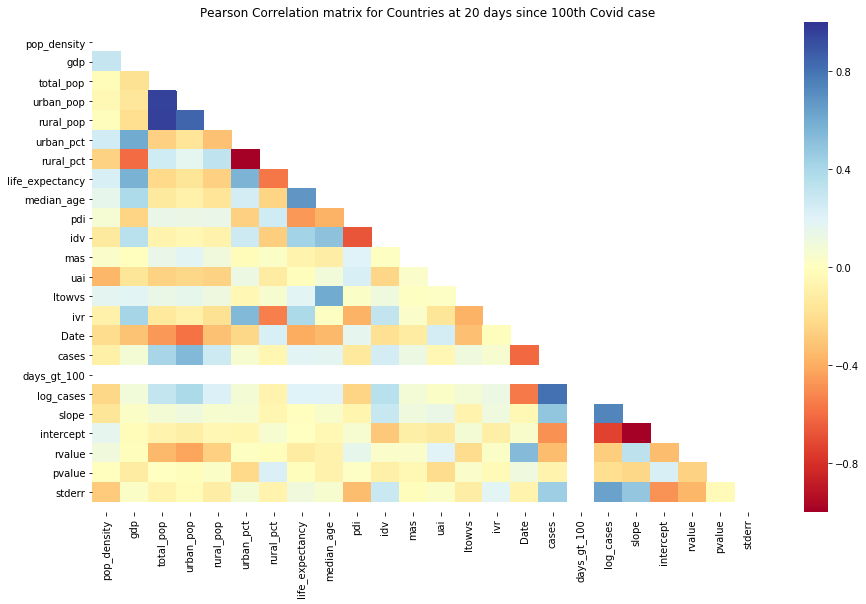

In [170]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr20)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr20,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 20 days since 100th Covid case')

In [171]:
corr20.to_csv('corrcases20.csv')

## Create subset of Countries that have reached 30 days > 100 cases

In [172]:
cases30 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 30).sum())>0]

In [173]:
cases30group = cases30.groupby('Code')

In [174]:
cases30slopes = (cases30group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))

In [175]:
merged30 = merged_data[merged_data.days_gt_100 == 30]

In [176]:
mergedcases30 = pd.merge(merged30, cases30slopes, on=["Code"])

In [177]:
# Export CSV
mergedcases30.to_csv('cases30.csv')  

In [178]:
corr30 = mergedcases30.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

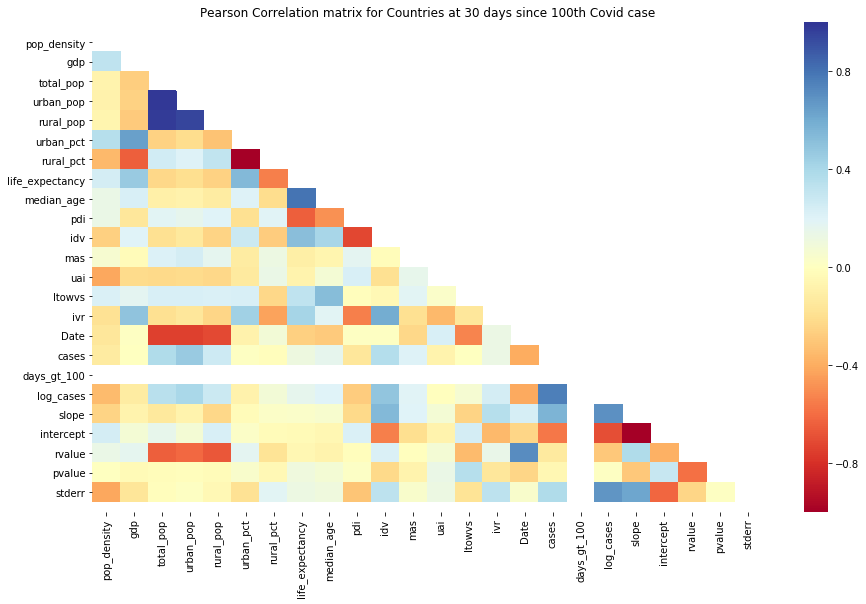

In [179]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr30)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr30,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 30 days since 100th Covid case')

In [180]:
corr30.to_csv('corrcases30.csv')

## Create subset of Countries that have reached 40 days > 100 cases

In [181]:
cases40 = merged_data[merged_data.groupby('Code')['days_gt_100'].transform(lambda x: (x == 40).sum())>0]

In [182]:
cases40group = cases40.groupby('Code')

In [183]:
cases40slopes = (cases40group.apply(lambda x: pd.Series(linregress(x['Date'],x['log_cases'])))\
        .rename(columns={
        0: 'slope',
        1: 'intercept',
        2: 'rvalue',
        3: 'pvalue',
        4: 'stderr'
    }))

In [184]:
merged40 = merged_data[merged_data.days_gt_100 == 40]

In [185]:
mergedcases40 = pd.merge(merged40, cases40slopes, on=["Code"])

In [186]:
# Export CSV
mergedcases40.to_csv('cases40.csv')  

In [187]:
corr40 = mergedcases40.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Countries at 40 days since 100th Covid case')

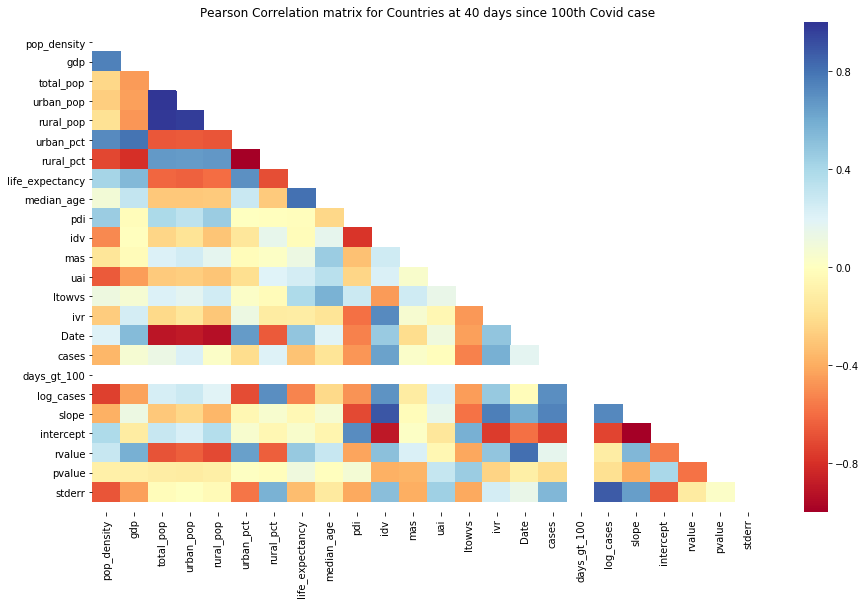

In [188]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr40)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr40,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Countries at 40 days since 100th Covid case')

In [189]:
corr40.to_csv('corrcases40.csv')

### Function to easily do a panel of scatterplots easily

In [67]:
def makePanelScatterplot(data_df, x_data,y_data,color_col,split_col):
    x_label = x_data
    y_label = y_data
    ylim_min = data_df[y_data].min()*1.05
    ylim_max = data_df[y_data].max()*1.05
    xlim_min = data_df[x_data].min()*1.05
    xlim_max = data_df[x_data].max()*1.05

    g = sns.lmplot(x=x_data, y=y_data, data=data_df,\
           hue=color_col, col=split_col,col_wrap=3)

        
    g = (g.set_axis_labels(x_label, y_label)
          .set(ylim=(ylim_min, ylim_max),xlim=(xlim_min, xlim_max))
          .fig.subplots_adjust(wspace=.02))

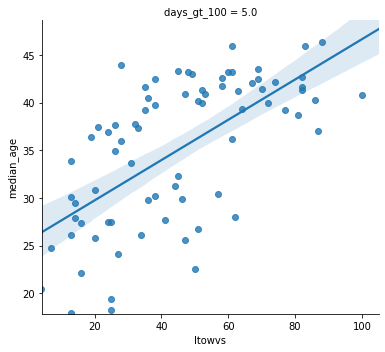

In [69]:
makePanelScatterplot(mergedcases5,"ltowvs","median_age","days_gt_100","days_gt_100")

In [ ]:

#merged_data['slope'] = merged_data.groupby('Code').diff()(lambda v: linregress(v.Date, v.cases)[0])
#merged_data['slope'] = (merged_data.groupby('Code')['cases'].apply(lambda x: x.shift().expanding().mean()))
#merged_data['slope'] = (merged_data.groupby('Code')['Date','cases'].apply(lambda x,y : x.shift().expanding().apply(lambda v: linregress([0], [1])[0])))